In [1]:
import duckdb
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config

In [2]:
def fetch_rushes():
	pass

In [3]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 #'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

team_stat_cols = [
 #'completions_team_roll',
 #'attempts_team_roll',
 'carries_team_roll',
 #'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'yards_per_carry_team_roll',
]
opp_stat_cols = [
#'completions_opp_roll',
 #'attempts_opp_roll',
 'carries_opp_roll',
 #'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll',
 'yards_per_carry_opp_roll',
]

game_context_cols = [
	"yardline_100",
	"down",
	"goal_to_go",
	"ydstogo",
	#"posteam_score",
	#"defteam_score",
	#"score_differential",
	#'quarter_seconds_remaining',
	#'half_seconds_remaining',
	#'game_seconds_remaining',
	#"wind",
	#"temp",
	#'spread_line',
	#'total_line',
]

x_cols = game_context_cols + ['is_first_down', 'is_second_down', 'is_third_down','is_fourth_down', 'first_down', 'touchdown'] #+ ['run_gap_encoded'] + rusher_stat_cols + team_stat_cols + opp_stat_cols 

In [4]:
x_cols

['yardline_100',
 'down',
 'goal_to_go',
 'ydstogo',
 'is_first_down',
 'is_second_down',
 'is_third_down',
 'is_fourth_down',
 'first_down',
 'touchdown']

In [5]:
rushes = Quack.query(f"""
select pbp.desc,pbp.game_id, pbp.yards_gained,
	case when pbp.run_gap = 'end' then 2
		when pbp.run_gap = 'tackle' then 1
		when pbp.run_gap = 'guard' then 0  else 1 end as run_gap_encoded,
	case when pbp.down = 1 then '1' else 0 end as is_first_down,
	case when pbp.down = 2 then '1' else 0 end as is_second_down,
	case when pbp.down = 3 then '1' else 0 end as is_third_down,
	case when pbp.down = 4 then '1' else 0 end as is_fourth_down,
                     pbp.first_down, pbp.touchdown,
	{', '.join(('pbp.' + x for x in game_context_cols))},
	{', '.join(('t.' + x for x in team_stat_cols))},
	{', '.join(('o.' + x for x in opp_stat_cols))},
	{', '.join(('r.' + x for x in rusher_stat_cols))},
	from pbp join team_feats as t 
	on pbp.posteam = t.team
	and pbp.game_id = t.game_id
	join opp_feats as o
	on pbp.defteam = o.opponent_team
	and pbp.game_id = o.game_id
	join player_weekly_agg as r
	on r.game_id = pbp.game_id
	and pbp.rusher_player_id = r.gsis_id
	and r.team = pbp.posteam
	and pbp.play_type = 'run'
	and pbp.yards_gained is not null
	and pbp.down is not null
    and pbp.penalty = 0
    and pbp.fumble = 0
""")

In [6]:
rushes[rusher_stat_cols] = rushes[rusher_stat_cols].fillna(0)
rushes['yards_shifted'] = rushes['yards_gained'] + 30

In [7]:
import torch
import torch.nn as nn

class CornHead(nn.Module):
	def __init__(self, in_features, num_classes):
		super().__init__()
		self.fc = nn.Linear(in_features, num_classes - 1)

	def forward(self, x):
		# logits shape: (batch_size, num_classes - 1)
		return self.fc(x)

class TransformerBlock(nn.Module):
	def __init__(self, n_hidden, num_heads=2, dropout=0.1):
		super().__init__()
		self.attn = nn.MultiheadAttention(embed_dim=n_hidden, num_heads=num_heads, batch_first=True)
		self.attn_norm = nn.LayerNorm(n_hidden)

		self.ff = nn.Sequential(
			nn.Linear(n_hidden, n_hidden * 2),
			nn.ReLU(),
			nn.Linear(n_hidden * 2, n_hidden),
			nn.Dropout(dropout)
		)
		self.ff_norm = nn.LayerNorm(n_hidden)

	def forward(self, x):
		# Self-attention + residual
		attn_out, _ = self.attn(x, x, x)
		x = self.attn_norm(x + attn_out)

		# Feedforward + residual
		ff_out = self.ff(x)
		x = self.ff_norm(x + ff_out)

		return x


class masked_model(nn.Module):
	def __init__(self, n_in=11, n_out=109, n_hidden=50, dropout_prob=0.1, num_layers=2):
		super().__init__()
		self.n_out = n_out
		self.n_in = n_in
		self.n_hidden = n_hidden
		# Embed each feature
		self.feature_embed = nn.Linear(1, n_hidden)
		# Stack of transformer blocks
		self.blocks = nn.ModuleList([
			TransformerBlock(n_hidden, num_heads=8, dropout=dropout_prob)
			for _ in range(num_layers)
		])
		# MLP after flattening
		self.main_layers = nn.Sequential(
			nn.Linear(n_in * n_hidden, n_hidden), nn.ReLU(),
			nn.Linear(n_hidden, n_hidden), nn.ReLU(),
			nn.Dropout(p=dropout_prob),
			nn.Linear(n_hidden, n_hidden), nn.ReLU(),
		)
		self.CornHead = CornHead(n_hidden, n_out)

	def forward(self, x):
		x = x.unsqueeze(-1) 
		x = self.feature_embed(x)                # [batch, n_in, n_hidden]
		# Pass through stacked transformer blocks
		for block in self.blocks:
			x = block(x)
		# Flatten tokens
		x = x.reshape(x.size(0), -1)             # [batch, n_in * n_hidden]
		# MLP
		x = self.main_layers(x)

		return self.CornHead(x)


In [8]:
class CornLoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, logits, y):
        """
        logits: (batch_size, num_classes-1) raw outputs
        y: (batch_size,) true labels in [0, num_classes-1]
        """
        batch_size = y.size(0)
        # create binary targets for each threshold
        y_expanded = y.unsqueeze(1).expand(-1, self.num_classes - 1)  
        thresholds = torch.arange(self.num_classes - 1, device=y.device).unsqueeze(0)
        target = (y_expanded > thresholds).float()

        # binary cross entropy per threshold
        loss = F.binary_cross_entropy_with_logits(logits, target, reduction='none')
        return loss.mean()

In [9]:
(rushes['yardline_100'] - rushes['yards_gained'] ).min()
#(rushes['yardline_100'] - rushes['yards_gained'] ).max()

np.float64(0.0)

In [10]:
X = rushes[x_cols].copy()
y = (rushes['yardline_100'] - rushes['yards_gained'] )
obs = len(X)
num_feats = len(X)

In [11]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)

def get_sample(num_samples):
	idx = np.random.randint(0,len(X_tensor), num_samples)
	return X_tensor[idx]

get_sample(2)

model = masked_model(
	n_in=len(x_cols),
	n_out=101,
	n_hidden=256,
	dropout_prob=0.
)
			# numerical value
c = get_sample(5)
print(c.shape)
pred = model(c)

torch.Size([5, 10])


In [16]:

def corn_probs(logits):
    """
    logits: (batch_size, num_classes-1)
    returns: (batch_size, num_classes) probability for each class
    """
    # sigmoid gives P(y > k) for each threshold
    p = torch.sigmoid(logits)  # shape: (batch, num_classes-1)

    # prepend 1 and append 0 to compute class probabilities
    # P(y = 0) = 1 - P(y > 0)
    # P(y = k) = P(y > k-1) - P(y > k)
    # P(y = last) = P(y > last-1)
    p = torch.cat([torch.ones(p.size(0), 1, device=p.device), p, torch.zeros(p.size(0), 1, device=p.device)], dim=1)
    probs = p[:, :-1] - p[:, 1:]
    return probs  # shape: (batch, num_classes)

In [30]:
def train_model(X, y, n_in, n_out,n_hidden=64, epochs=20, batch_size=512):

	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	y = torch.tensor(y,dtype=torch.long).to(device)
	# Define the model, loss function, and optimizer

	X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
	model = model = masked_model(
	n_in=n_in,
	n_out=n_out,
	n_hidden=n_hidden,
	dropout_prob=0.
	).to(device)
	criterion = CornLoss(n_out)  # Suitable for classification
	#criterion_mse = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)

	num_samples = X_tensor.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 5  # 20% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices

	Xtr = X_tensor[train_indices].to(device)
	Xtst = X_tensor[test_indices].to(device)
	train_y = y[train_indices].to(device)
	test_y =  y[test_indices].to(device)

	# Training loop
	epochs = epochs
	batch_size = 64

	for epoch in range(epochs):
		model.train()
		permutation = torch.randperm(Xtr.size(0))
		epoch_loss = 0

		for i in range(0, Xtr.size(0), batch_size):
			indices = permutation[i:i + batch_size]
			batch_x, batch_y = Xtr[indices], train_y[indices]

			optimizer.zero_grad()
			outputs = model(batch_x)  # Shape: [batch_size, n_out]

			loss = criterion(outputs, batch_y)
			loss.backward()
			optimizer.step()

			epoch_loss += loss.item()

		print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(Xtr):.4f}")

		# Evaluation on the test set
	model.eval()
	with torch.no_grad():
		test_preds = model(Xtst)
		test_loss = criterion(test_preds, test_y).item()
		
		pred_classes = corn_predict(test_preds)
		accuracy = (pred_classes == test_y).float().mean().item()

		probs = corn_probs(test_preds)
		sampled = torch.multinomial(probs[0], 100, replacement=True)
		sampled = torch.clamp(sampled, max=76)
		avg = sampled.double().mean().item()

	print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
	plt.hist(probs[0].cpu(), alpha=0.5, color='r')
	plt.hist(test_y.cpu(), alpha=0.5, color='b')
	return model

In [32]:
import torch

def corn_predict(logits):
    """
    logits: (batch_size, num_classes-1)
    returns: predicted class indices (batch_size,)
    """
    probs = torch.sigmoid(logits)             # P(y > k) for each threshold
    decisions = (probs > 0.5).int()           # 1 if y > k
    return decisions.sum(dim=1)               # count thresholds passed


rush_yards_model = train_model(X,y, len(x_cols), 101, n_hidden = 256, epochs=5)


Epoch 1/5, Loss: 0.0067
Epoch 2/5, Loss: 0.0066
Epoch 3/5, Loss: 0.0066
Epoch 4/5, Loss: 0.0066
Epoch 5/5, Loss: 0.0066


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [18]:

rush_yards_model = rush_yards_model.to('cpu')
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
	'rush_yard_cols':x_cols
}
feature_config

update_config(feature_config)

Actual mean: 11.08, Model mean: 13.49
number of datapoints: 678


(-2.0, 25.0)

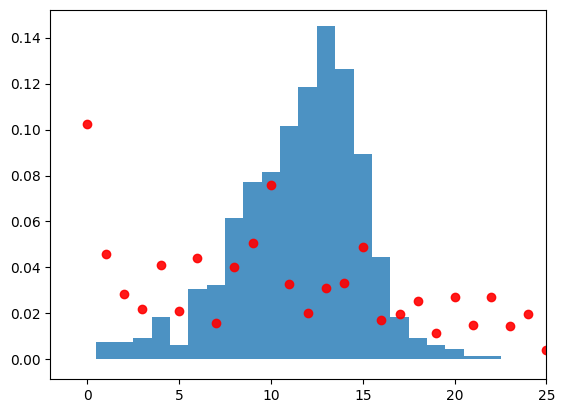

In [26]:
def sample_model_yardline(yard, down):
	inp = rushes.loc[(rushes.down == down) & (rushes.yardline_100==yard), x_cols].copy()
	y = rushes.loc[(rushes.down == down) & (rushes.yardline_100==yard), ['yards_gained', 'yardline_100']]
	y = (y['yardline_100'] - y['yards_gained'] )
	inp =  torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp)#.mean(0).detach().numpy()
	probs = corn_probs(out).mean(0).detach().numpy()
	bins = np.arange(0 + 0.5, 100 + 0.5 + 1, 1)
	plt.hist(y, bins=bins, density=True, alpha=0.8)

	actual_mean = y.mean()
	model_mean = np.arange(len(probs)) @ probs  # adjust if 0th class = -30
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	print(f'number of datapoints: {len(inp)}')
	return probs

yard = 15
down = 1

plt.scatter(range(0,101),sample_model_yardline(yard, down), color='r', alpha=0.9)
plt.xlim(-2,yard + 10)

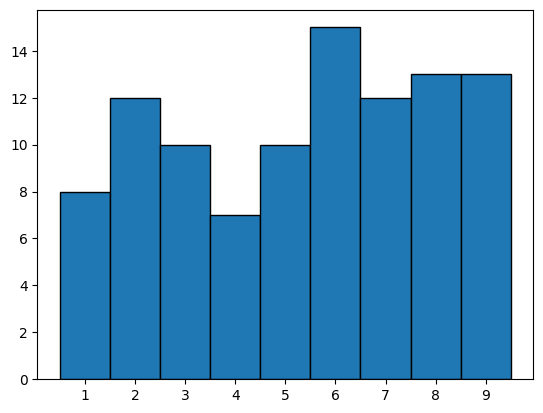

In [ ]:

data = np.random.randint(1, 10, 100)

# bins centered on integers
bins = np.arange(data.min() - 0.5, data.max() + 1.5, 1)

counts, edges = np.histogram(data, bins=bins)
centers = 0.5 * (edges[1:] + edges[:-1])

plt.bar(centers, counts, width=1, align='center', edgecolor='k')
plt.xticks(range(data.min(), data.max() + 1))
plt.show()

In [ ]:
test_inp = torch.tensor(inp.values, dtype=torch.float32)

NameError: name 'inp' is not defined

torch.Size([1, 21])
torch.Size([1, 21])
torch.Size([1, 21])
torch.Size([1, 21])


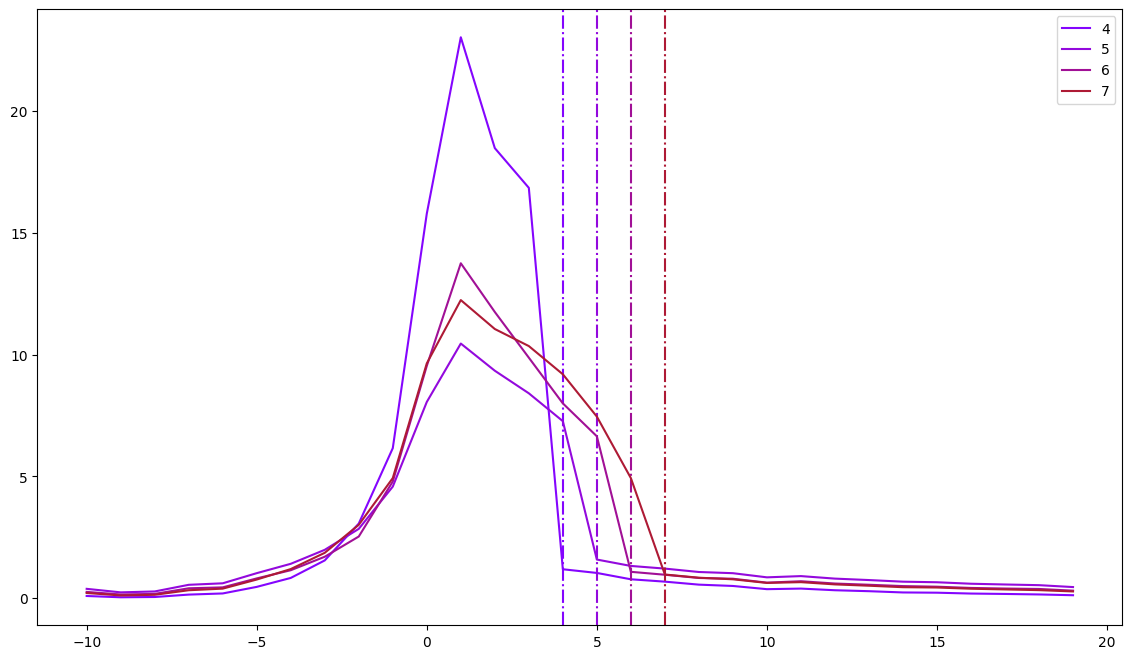

In [ ]:
import matplotlib.cm as cm
colormap = cm.gnuplot
plt.figure(figsize=(14, 8))
num_yardlines = 15
for yardline in range(4,8):

    color = colormap(yardline / num_yardlines) 
    down=1
    test = rushes.loc[rushes.yardline_100==yardline]
    xx = torch.Tensor(test[x_cols].sample(1).values)
    print(xx.shape)
    with torch.no_grad():
        xy = rush_yards_model(xx)
        xy[:,30+yardline:] /= 2
        xy = (100 * F.softmax(xy,dim=1))[0]
        x_range = range(-10,20)
    plt.axvline(yardline, color=color, linestyle='-.')
    plt.plot(x_range, xy[20:50], label=yardline, color=color)
    plt.legend()